# Extracting Data

In [36]:
from datasets import load_dataset
import pandas as pd
import os

# Load the dataset
dataset = load_dataset("Marqo/deepfashion-multimodal")

# Sample 2000 images and captions
sampled_data = dataset['data'].shuffle(seed=42).select(range(400))

# Prepare directories
output_dir = 'downloaded_images'
os.makedirs(output_dir, exist_ok=True)

# Prepare images and captions
images = []
captions = []

for index, item in enumerate(sampled_data):
    # Access the image directly from the 'image' attribute
    image = item['image']  # Assuming 'image' is a PIL Image object or similar
    caption = item['text']  # Access the caption from the 'text' attribute

    # Save the image
    image_path = os.path.join(output_dir, f'image_{index + 1}.jpg')  # Save with a unique name
    image.save(image_path, format='JPEG')  # Save the image using PIL

    images.append(image_path)  # Store the path of the saved image
    captions.append(caption)  # Append the caption

# Create a DataFrame
df = pd.DataFrame({
    'image': images,
    'caption': captions
})

# Save to CSV
df.to_csv('sampled_images_captions.csv', index=False)

print("Images and captions saved to 'sampled_images_captions.csv'")


d:\CAPSTONE\Project\.venv\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Tanishq\.cache\huggingface\hub\datasets--Marqo--deepfashion-multimodal. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating data split: 100%|██████████| 42537/42537 [00:00<00:00, 63296.37 examples/s]


Images and captions saved to 'sampled_images_captions.csv'


# Using a Custom VAE and then adding Gaussian Noise

Noisy embeddings saved to 'noisy_embeddings.npy'
Final noisy embedding dimensions: (400, 128, 128)


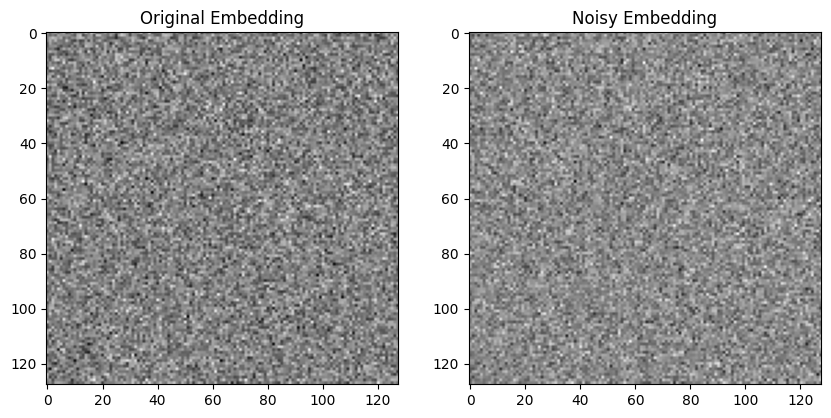

In [8]:
import torch
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader
from datasets import load_dataset
from torchvision import models
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Assuming VAE is already defined (either pre-trained or custom).
# For simplicity, using a basic VAE model for encoding (you can replace it with a specific VAE).

class SimpleVAE(nn.Module):
    def __init__(self):
        super(SimpleVAE, self).__init__()
        self.encoder = models.resnet18(pretrained=True)
        self.encoder.fc = nn.Linear(self.encoder.fc.in_features, 128 * 128)  # Output size 128x128

    def forward(self, x):
        x = self.encoder(x)
        return x.view(-1, 128, 128)  # Reshape to (batch_size, 128, 128)

# Load the dataset
dataset = load_dataset("LeroyDyer/winogroud_text_to_imaget_BASE64")

# Sample 2000 images
sampled_data = dataset['train'].shuffle(seed=42).select(range(400))

# Prepare a transform to normalize the images and resize them to the input size expected by VAE
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image to a standard size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained model
])

# Initialize the VAE model
vae = SimpleVAE()

# Move to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae.to(device)

# Prepare data for encoding
image_paths = []
encoded_images = []


# Loop over the dataset and apply the transform and encode the images
for item in sampled_data:
    # Directly access and convert the image (no need to use Image.open() here)
    image = item['image'].convert('RGB')  # Convert to RGB if needed
    
    # Apply transformations (resize, normalize, etc.) and add batch dimension
    image = transform(image).unsqueeze(0).to(device)

    # Get the embedding from the VAE
    with torch.no_grad():
        embedding = vae(image)

    # Append the embedding to the list
    encoded_images.append(embedding.cpu().numpy().squeeze())  # Convert to numpy and remove batch dimension


# Convert the list of embeddings into a numpy array
encoded_images = np.array(encoded_images)

# Adding Gaussian noise using cosine schedule
timesteps = 4000
cosine_schedule = np.cos(np.pi * (np.linspace(0, timesteps, timesteps) / timesteps))

# Add Gaussian noise with cosine schedule
noisy_embeddings = []
for embedding in encoded_images:
    noise = np.random.randn(*embedding.shape) * cosine_schedule[-1]  # Add noise based on the schedule
    noisy_embedding = embedding + noise
    noisy_embeddings.append(noisy_embedding)

noisy_embeddings = np.array(noisy_embeddings)

# Save noisy embeddings to a .npy file
np.save("noisy_embeddings.npy", noisy_embeddings)
print("Noisy embeddings saved to 'noisy_embeddings.npy'")

# Print the dimensions of the final noisy embeddings
print(f"Final noisy embedding dimensions: {noisy_embeddings.shape}")

# Optionally, visualize a few embeddings and their noisy versions
plt.figure(figsize=(10, 5))

# Show original and noisy embeddings for the first image
plt.subplot(1, 2, 1)
plt.imshow(encoded_images[0], cmap='gray')
plt.title("Original Embedding")

plt.subplot(1, 2, 2)
plt.imshow(noisy_embeddings[0], cmap='gray')
plt.title("Noisy Embedding")

plt.show()


# Generating the Text Embeddings using CLIP

In [3]:
import torch
from transformers import CLIPProcessor, CLIPModel

# Load the CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model.to(device)

# List to store text embeddings
text_embeddings = []

# Loop over the dataset to generate text embeddings
for item in sampled_data:
    caption = item['text']  # Extract caption from the dataset

    # Process the text and get the embeddings
    inputs = clip_processor(text=caption, return_tensors="pt", padding=True, truncation=True, max_length=77)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to GPU if available

    # Get the text embeddings from the CLIP model
    with torch.no_grad():
        text_embedding = clip_model.get_text_features(**inputs)

    # Append the text embedding (converting it to a numpy array for easier handling)
    text_embeddings.append(text_embedding.cpu().numpy().squeeze())

# Convert the list of text embeddings into a numpy array
text_embeddings = np.array(text_embeddings)

# Print out the dimensions of the text embeddings
print(f"Text Embedding Dimensions: {text_embeddings.shape}")


Text Embedding Dimensions: (400, 512)


# U-NET encoder block

In [ ]:
import torch
import torch.nn as nn

# Check if a GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class UNetEncoder(nn.Module):
    def __init__(self, image_embedding_size=128, text_embedding_size=512, latent_dim=256):
        super(UNetEncoder, self).__init__()

        # Projection layer to match image embeddings and text embeddings
        self.proj_text = nn.Linear(text_embedding_size, image_embedding_size * image_embedding_size)  # 512 -> 128x128

        # First convolutional layer
        self.conv1 = nn.Conv2d(image_embedding_size + image_embedding_size, 64, kernel_size=3, stride=2, padding=1)
        self.relu1 = nn.ReLU(inplace=True)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.relu2 = nn.ReLU(inplace=True)

        # Cross-attention layer (simplified)
        self.cross_attention = nn.MultiheadAttention(embed_dim=image_embedding_size, num_heads=8, dropout=0.1)

        # Flatten layer to get the latent representation
        self.flatten = nn.Flatten()
        self.fc_latent = nn.Linear(128 * 32 * 32, latent_dim)

    def forward(self, image_embedding, text_embedding):
        # Project text embeddings to match the image embedding size
        text_projection = self.proj_text(text_embedding).view(-1, 128, 128)  # Reshaping to (batch_size, 128, 128)

        # Ensure text_projection has the correct shape (batch_size, channels, height, width)
        text_projection = text_projection.unsqueeze(1)  # Shape: [batch_size, 128, 128, 1]
        text_projection = text_projection.expand(-1, image_embedding.size(1), -1, -1)  # [batch_size, channels, height, width]

        # Ensure image_embedding has 4 dimensions (batch_size, channels, height, width)
        if len(image_embedding.shape) == 3:  # If image_embedding is 3D (batch_size, channels, height), add a dimension for width
            image_embedding = image_embedding.unsqueeze(3)  # Shape: [batch_size, channels, height, 1]

        # Concatenate image embeddings with projected text embeddings along the channel axis
        combined_input = torch.cat((image_embedding, text_projection), dim=1)  # Shape: [batch_size, 256, height, width]

        # First convolution and downsampling
        x1 = self.conv1(combined_input)
        x1 = self.relu1(x1)

        # Second convolution and downsampling
        x2 = self.conv2(x1)
        x2 = self.relu2(x2)

        # Store the skip connections (after each conv layer)
        skip1 = x1  # Output of first convolution
        skip2 = x2  # Output of second convolution

        # Apply cross-attention between the image feature map and text embedding
        x = x2.view(x2.size(0), x2.size(1), -1).permute(2, 0, 1)  # Prepare for attention (seq_len, batch_size, channels)
        attention_output, _ = self.cross_attention(x, x, x)  # Self-attention on image and text features

        # Flatten the features after attention
        x = attention_output.permute(1, 2, 0).contiguous().view(x.size(1), -1)

        # Final latent representation
        latent = self.fc_latent(x)

        # Return the latent representation along with the skip connections
        return latent, skip1, skip2


# Example tensors (move them to the chosen device)
noisy_image_embeddings = torch.randn(400, 128, 128, 128).to(device)  # Example tensor (4D)
text_embeddings = torch.randn(400, 512).to(device)  # Example tensor

# Initialize the encoder and move it to the device
encoder = UNetEncoder().to(device)

# Forward pass to get latent representation
latent_representation, skip1, skip2 = encoder(noisy_image_embeddings, text_embeddings)

# Print the latent representation shape
print(f"Latent Representation Shape: {latent_representation.shape}")


Latent Representation Shape: torch.Size([400, 256])


# Bottleneck of the U-Net

In [4]:
import torch
import torch.nn as nn

class UNetBottleneck(nn.Module):
    def __init__(self, image_embedding_size=128, text_embedding_size=512, latent_dim=256):
        super(UNetBottleneck, self).__init__()

        # Project text embeddings to match the channel dimension of image embeddings
        self.proj_text = nn.Linear(text_embedding_size, image_embedding_size * image_embedding_size)

        # Cross-attention layer to align image features with text description
        self.cross_attention = nn.MultiheadAttention(embed_dim=image_embedding_size, num_heads=8, dropout=0.1)

        # Residual block for stable gradients and feature preservation
        self.residual_block1 = nn.Sequential(
            nn.Conv2d(image_embedding_size, image_embedding_size, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(image_embedding_size, image_embedding_size, kernel_size=3, padding=1)
        )

        self.residual_block2 = nn.Sequential(
            nn.Conv2d(image_embedding_size, image_embedding_size, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(image_embedding_size, image_embedding_size, kernel_size=3, padding=1)
        )

        # Self-attention layer to refine features
        self.self_attention = nn.MultiheadAttention(embed_dim=image_embedding_size, num_heads=8, dropout=0.1)

        # Output layer to provide the refined latent representation
        self.output_layer = nn.Linear(image_embedding_size * image_embedding_size, latent_dim)

    def forward(self, image_embedding, text_embedding):
        # Project text embeddings to match the image embedding size and reshape
        text_projection = self.proj_text(text_embedding).view(-1, image_embedding.size(1), image_embedding.size(2), image_embedding.size(3))
        
        # Concatenate image embeddings with projected text embeddings
        combined_input = image_embedding + text_projection

        # Apply cross-attention (flatten spatial dimensions for attention, then reshape back)
        combined_input_flat = combined_input.view(combined_input.size(0), combined_input.size(1), -1).permute(2, 0, 1)
        attn_output, _ = self.cross_attention(combined_input_flat, combined_input_flat, combined_input_flat)
        attn_output = attn_output.permute(1, 2, 0).view(combined_input.size(0), combined_input.size(1), combined_input.size(2), combined_input.size(3))

        # Pass through residual blocks
        res1 = self.residual_block1(attn_output) + attn_output  # Residual connection
        res2 = self.residual_block2(res1) + res1

        # Apply self-attention (flatten spatial dimensions for attention, then reshape back)
        res_flat = res2.view(res2.size(0), res2.size(1), -1).permute(2, 0, 1)
        self_attn_output, _ = self.self_attention(res_flat, res_flat, res_flat)
        self_attn_output = self_attn_output.permute(1, 2, 0).view(res2.size(0), res2.size(1), res2.size(2), res2.size(3))

        # Flatten and project to the final latent representation
        latent = self.output_layer(self_attn_output.view(self_attn_output.size(0), -1))

        return latent


# Decoder block of the U-Net

In [ ]:

import torch
import torch.nn as nn

class UNetDecoder(nn.Module):
    def __init__(self, latent_dim=256, image_embedding_size=128, text_embedding_size=512, num_heads=8):
        super(UNetDecoder, self).__init__()

        # Projection layer to match image embeddings and text embeddings for the cross-attention
        self.proj_text = nn.Linear(text_embedding_size, latent_dim)  # Project text embedding to latent_dim size

        # Upsampling layers (Transpose convolutions)
        self.upconv1 = nn.ConvTranspose2d(latent_dim + image_embedding_size, 128, kernel_size=4, stride=2, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.upconv2 = nn.ConvTranspose2d(128 + image_embedding_size, 64, kernel_size=4, stride=2, padding=1)
        self.relu2 = nn.ReLU(inplace=True)

        # Cross-attention layer
        self.cross_attention = nn.MultiheadAttention(embed_dim=latent_dim, num_heads=num_heads, dropout=0.1)

        # Noise prediction layer
        self.noise_predictor = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)  # To predict noise at each step
        
        # Final convolution to map features back to the pixel space (size 128x128)
        self.final_conv = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)  # RGB image output

    def forward(self, latent_representation, skip1, skip2, text_embedding, time_step):
        # Project text embedding to match the latent dimension size
        text_projection = self.proj_text(text_embedding).unsqueeze(-1).unsqueeze(-1)  # Shape: (batch_size, latent_dim, 1, 1)

        # Ensure latent_representation has the correct shape (batch_size, latent_dim, height, width)
        latent_representation = latent_representation.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, skip2.size(2), skip2.size(3))

        # First upsampling (with skip connection)
        x = torch.cat((latent_representation, skip2), dim=1)  # Concatenate latent and skip connection
        x = self.upconv1(x)  # Upsample
        x = self.relu1(x)

        # Second upsampling (with skip connection)
        x = torch.cat((x, skip1), dim=1)  # Concatenate with the skip connection
        x = self.upconv2(x)  # Upsample
        x = self.relu2(x)

        # Apply cross-attention between the upsampled features and text embedding
        x_reshaped = x.view(x.size(2) * x.size(3), x.size(1), x.size(0)).permute(2, 0, 1)  # Prepare for attention
        attention_output, _ = self.cross_attention(x_reshaped, x_reshaped, x_reshaped)  # Self-attention
        x = attention_output.permute(1, 2, 0).contiguous().view(x.size(0), x.size(1), x.size(2), x.size(3))

        # Noise prediction (this can be used for noise removal in the denoising process)
        predicted_noise = self.noise_predictor(x)  # Predict the noise at each step

        # Final convolution to map features to pixel space
        final_output = self.final_conv(x)  # Map to RGB space (128x128)

        return final_output, predicted_noise

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example latent representation, skip connections from encoder, text embeddings
latent_representation = torch.randn(400, 256).to(device)  # Shape: [batch_size, latent_dim]
skip1 = torch.randn(400, 128, 32, 32).to(device)  # Encoder skip connection (output of conv2)
skip2 = torch.randn(400, 128, 64, 64).to(device)  # Encoder skip connection (output of conv1)
text_embedding = torch.randn(400, 512).to(device)  # Text embeddings (from CLIP model)
time_step = torch.randint(0, 4000, (400,)).to(device)  # Example time steps (from 0 to 4000)

# Initialize the decoder
decoder = UNetDecoder().to(device)

# Forward pass
final_image, predicted_noise = decoder(latent_representation, skip1, skip2, text_embedding, time_step)

# Print output shapes
print(f"Final Image Shape: {final_image.shape}")
print(f"Predicted Noise Shape: {predicted_noise.shape}")


: 

# Training Loop

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPProcessor, CLIPModel
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Assuming the SimpleVAE, UNetEncoder, Bottleneck, and Decoder are defined as before

# Custom Dataset Class (Using noisy embeddings from the VAE)
class CustomImageCaptionDataset(Dataset):
    def __init__(self, csv_file, noisy_embeddings, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_paths = self.data['image'].tolist()  # Image file paths
        self.captions = self.data['caption'].tolist()  # Corresponding captions
        self.noisy_embeddings = noisy_embeddings  # Noisy image embeddings
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Get the noisy embedding for the image
        noisy_embedding = torch.tensor(self.noisy_embeddings[idx], dtype=torch.float32)
        
        # Get the caption
        caption = self.captions[idx]

        return noisy_embedding, caption

# Load noisy embeddings (already generated in the previous code)
noisy_embeddings = np.load('noisy_embeddings.npy')  # Assuming this is saved previously

# Define transformations for the images (optional, as we're working with embeddings)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to match expected input size (if working with images directly)
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Example normalization
])

# Initialize the dataset and dataloader
dataset = CustomImageCaptionDataset(csv_file='sampled_images_captions.csv', 
                                    noisy_embeddings=noisy_embeddings, 
                                    transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Initialize the CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model.to(device)

# Initialize the UNetEncoder, Bottleneck, and Decoder
unet_encoder = UNetEncoder().to(device)
bottleneck = UNetBottleneck().to(device)  # Assuming you have the Bottleneck class
decoder = UNetDecoder().to(device)  # Assuming you have the Decoder class

# Define loss function (e.g., MSE loss for image reconstruction)
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(list(unet_encoder.parameters()) + 
                             list(bottleneck.parameters()) + 
                             list(decoder.parameters()), lr=1e-4)

# Number of training epochs
epochs = 10

# Training loop
for epoch in range(epochs):
    unet_encoder.train()
    bottleneck.train()
    decoder.train()

    running_loss = 0.0
    for batch_idx, (noisy_embeddings, captions) in enumerate(dataloader):
        # Move noisy embeddings and captions to device
        noisy_embeddings = noisy_embeddings.to(device)
        
        # Process captions to get text embeddings from CLIP
        inputs = clip_processor(text=captions, return_tensors="pt", padding=True, truncation=True, max_length=77)
        inputs = {key: value.to(device) for key, value in inputs.items()}
        
        with torch.no_grad():
            text_embeddings = clip_model.get_text_features(**inputs)
        
        # Forward pass through the UNet Encoder
        latent, skip1, skip2 = unet_encoder(noisy_embeddings, text_embeddings)

        # Forward pass through the Bottleneck
        bottleneck_output = bottleneck(latent, skip1, skip2)

        # Forward pass through the Decoder
        output_image = decoder(bottleneck_output, skip1, skip2, text_embedding, time_step)


        # Calculate the loss (for simplicity, MSE between the output and the input noisy embeddings)
        loss = criterion(output_image, noisy_embeddings)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(dataloader)}")

print("Training complete!")


# Querying


In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel

# Assuming you have initialized the models and have the required device

# Function to query the model with a random text input
def query_model(text_prompt, unet_encoder, bottleneck, decoder, clip_model, clip_processor, device):
    # Process the text input to get 512-dimensional embeddings
    inputs = clip_processor(text=[text_prompt], return_tensors="pt", padding=True, truncation=True, max_length=77)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Get the text embeddings from the CLIP model (this will be a 512-dimensional vector)
    with torch.no_grad():
        text_embedding = clip_model.get_text_features(**inputs)

    # Example: Generate a random noisy embedding (this should be from your dataset in real use)
    noisy_embedding = torch.randn(1, 128, 128, 128).to(device)  # Example random noisy image embedding

    # Forward pass through the UNet Encoder to get latent and skip connections
    latent, skip1, skip2 = unet_encoder(noisy_embedding, text_embedding)

    # Forward pass through the Bottleneck
    bottleneck_output = bottleneck(latent, skip1, skip2)

    # Example time step for inference
    time_step = torch.randint(0, 4000, (1,)).to(device)

    # Forward pass through the Decoder to generate the output image
    output_image, _ = decoder(bottleneck_output, skip1, skip2, text_embedding, time_step)

    return output_image


